# 决策树

决策树模型用一系列树形结构的问题来对实例进行分类，它也可以表示给定特征条件下的类的条件概率分布$P(Y|X)$（见统计学习方法p56）。

**决策树算法特点**  
优点：计算复杂度不高，输出结果易于理解，数据有缺失也能跑，可以处理不相关特征。  
缺点：容易过拟合。  
适用数据类型：数值型和标称型优点：计算复杂度

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] # deal with the Chinese characters

import pandas as pd
import networkx as nx

import xgboost as xgb
from sklearn import tree

## 决策树的学习
决策树由结点和有向边构成。对一个样本的分类起始于根结点，在每个内部结点处对某个特定的属性进行判断，并沿着对应属性值的边到达子结点。反复划分直到叶结点处。一个样本以叶结点的标记作为分类的结果。  
决策树学习要从训练数据集中归纳出一组分类规则，它包括三个部分：**特征选择**、**决策树的生成**，以及**决策树的修剪**。

### 决策树的生成
决策树学习的损失函数是正则化的极大似然函数，但由于最大化似然函数是个NP完全问题，所以一般采用下述启发式方法来学习次优的决策树。

```
TreeGenerate(D, A)  //D={(x1, y1), (x2, y2), ..., (xm, ym)}是训练集，A={a1, a2, ..., ad}是属性集
 1  生成结点node
 2  if D中的样本属于同一个类别C:   //同一属性无需划分
 3      将node标记为C类的叶结点
 4      return node
 5  if A==Φ or D中样本在A上取值相同:  //无法划分的情况
 6      将node标为叶结点，它的标记为D中样本数最多的类
 7      return node
 8  从A中选择最优划分的属性a* //由特征选择过程给出
 9  for a*的所有可能值av*:
10     取出值为av*的样本子集Dv
11     if Dv == Φ:
12         新建一个分支结点node2，并标记为叶结点，将其类别设为D中样本最多的类
13     else:
14         以TreeGenerate(Dv, A\{a*})作为分支结点node2
15     用分支条件a*==av*的edge将node和node2相连
16  return node
```


In [20]:
def split_attribute(X, y, attr_axis):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    attr_axis : integer, [0, n)
        the index of attribute to split
        
    Returns
    ---------
    Xs_new : list of numpy array, [(m1, n), (m2, n), ...]
        the freatures of splitted examples
    ys_new : list of numpy array, [(m1, 1), (m2, 1), ...]
        the label of splitted examples
    """
    xs = set(X[:, attr_axis].tolist())
    Xs_new, ys_new = [], []
    for x in xs:
        filter_ = (X[:, attr_axis]==x)
        Xs_new.append(X[filter_, :])
        ys_new.append(y[filter_, :])
    return Xs_new, ys_new

def generate_tree(X, y, scorefunc, tol=0.01, maxdepth=None, filter_=None):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature
    tol : float, >0., default: 0.01
        the minimum score which will split the feature
    maxdepth : integer, or None (default)
        the maximum depth of the tree
    filter_ : array of bools (n, ), or None (default)
        if the corresponding term of feature in filter_ is
        False, the feature will not be splitted
        
    Returns
    ---------
    tree : dict
        {cond1 : subtree1, cond2 : subtree2, ...} for tree:
                       root
            cond1 /     \ cond2
                     /         \
           subtree1    subtree2
    """
    # create a new node
    tree = {}

    m, n = X.shape
    if filter_ is None:
        filter_ = np.array([True]*n, dtype=bool)

    # count the numbers of y
    ycounts = {}
    for yval in y.flat:
        if not yval in ycounts:
            ycounts[yval] = 1
        else:
            ycounts[yval] += 1

    # find the most frequent one
    yfreq = sorted(ycounts.items(), key=lambda t: t[1], reverse=True)[0][0]
    
    # case 0: all the case with the same label
    if ycounts[yfreq] == m:
        tree[None] = (None, y[0, 0])
        return tree

    # default case: the most frequent label
    tree[None] = (None, yfreq)
    
    # case 1: reach the maxdepth
    if maxdepth is not None and maxdepth <= 1:
        return tree
    
    # case 2: no attribute remains
    if not filter_.any():
        return tree
    
    # case 3: all the features are the same
    i = 0
    while i<n and (not filter_[i] or (X[: i]==X[0, i]).all()):
        i += 1
    if i == n:
        return tree

    # find the best feature
    best_score = -1.
    best_index = None
    best_Xs_new, best_ys_new = None, None
    for i in range(n):
        if filter_[i]:
            Xs_new, ys_new = split_attribute(X, y, i)
            score = scorefunc(y, ys_new)
            if score > best_score:
                best_score = score
                best_index = i
                best_Xs_new = Xs_new
                best_ys_new = ys_new

    # case 4: no improvement
    if best_score < tol:
        return tree
    
    # recursively generate the trees
    filter_[best_index] = False
    tree[None] = (best_index, yfreq)
    for X_new, y_new in zip(best_Xs_new, best_ys_new):
        if maxdepth is None:
            child = generate_tree(X_new, y_new, scorefunc,
                                  tol=tol, maxdepth=maxdepth, filter_=filter_)
        else:
            child = generate_tree(X_new, y_new, scorefunc,
                                  tol=tol, maxdepth=maxdepth-1, filter_=filter_)
        tree[X_new[0, best_index]] = child
    return tree

def classify_one(x, tree):
    """
    Parameters
    -------------
    x : numpy array, (n, )
        a feature vector for a particular sample
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : object
        the label of the input sample
    """
    if tree[None][0] is not None:
        index = tree[None][0]
        xval = x[index]
        if xval in tree:
            return classify(x, tree[xval])
    return tree[None][1]

def classify(X, tree):
    """
    Parameters
    -------------
    X : numpy array, (m, n)
        a feature vector for samples
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : numpy array, (m, 1)
        the label of the input samples
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    m = X.shape[0]
    y = []
    for i in range(m):
        x = X[i, :]
        y.append(classify_one(x, tree))
    return np.array(y).reshape(-1, 1)

In [26]:
from collections import deque

def tree_visualize(tree, colnames=None):
    """
    Parameters
    -------------
    tree : dict
        the generated decision tree
    colnames : list, or None (default)
        the label of the column
        
    Returns
    --------
    fg : matplotlib.figure.Figure
        the figure of the decision tree
    """
    g = nx.Graph()

    node_labels, edge_labels = {}, {}
    next_index = 0
    def dfs(subtree, parent_index=None):
        nonlocal node_labels, edge_labels, next_index

        this_index = next_index
        g.add_node(this_index)
        if parent_index is not None:
            g.add_edge(parent_index, this_index)

        misc = subtree[None]
        node_labels[this_index] = misc[1]
        next_index += 1
        
        for key, dict_ in subtree.items():
            if key is None: continue
            if colnames is None:
                edge_labels[(this_index, next_index)] = 'A[{}]={}'.format(misc[0], key)
            else:
                edge_labels[(this_index, next_index)] = '{}={}'.format(colnames[misc[0]], key)
            dfs(dict_, this_index)
    
    dfs(tree)

    fg, ax = plt.subplots(figsize=(17, 8))
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
    nx.draw_networkx(g, pos, ax=ax, arrows=True, node_color='0.7', node_size=400,
        with_labels=True, labels=node_labels, font_size=14, font_color='k'
        )
    nx.draw_networkx_edge_labels(g, pos, ax=ax, edge_labels=edge_labels, font_size=11)
    
    ax.axis('off')
    return fg

### 特征选择
定性的讲，如果一个特征使得其分支结点的样本类型的纯净度越高，则该特征越优秀。我们有几种方式来定量地描述样本的纯净度：**信息增益**、**增益率**、**Gini系数**。
不同的选择方式对应了不同的决策树算法：  
`ID3`算法：信息增益，倾向于值较多的属性；
`C4.5`算法：增益率，倾向于值较少的属性；
`CART`算法：Gini系数。

#### 信息增益与信息增益率
**熵**：描述随机变量的随机性，$H(X) = -\sum_k p_k \log_2 p_k$，其中$p_i = P(X=x_i)$。随机变量分布的不确定性越大，熵越大。
当表示一组样本的类型不确定性时，我们用$Y$的经验分布$p_k=P(Y=y_k)=\frac{n_k}{N}$来代替其真实的概率分布，即$H(D)=-\sum_{k=1}^{|{\mathcal Y}|} \frac{n_k}{N} \log_2 \left (\frac{n_k}{N} \right)$。

**条件熵**：描述已知随机变量$X$的条件下随机变量$Y$的不确定性：$H(Y|X) = \sum_k P(X=x_k) H(Y| X=x_k)$。
对于一组样本而言，$H(D|A) = \sum_k \frac{n_k}{N} H(D_k)$。

**信息增益**：描述得知特征$X$后使$Y$的信息不确定减少的程度：$Gain(D,A)=H(D)-H(D|A)$。

**信息增益率**：$GainRatio(D, A)= Gain(D, A)/H_A(D)$，其中$H_A(D)=-\sum_v \frac{|D_v|}{|D|} \ln \frac{|D_v|}{|D|}$称为属性的**固有值**（intrinsic value），属性A的可能值越多，$H_A$越大，$GainRatio$越小。

#### 基尼系数
**Gini系数**：数据集中抽出两个样本，其类别标记不一致的概率，即$Gini(D)=\sum_k p_k (1-p_k)=1-\sum_k p_k^2$。显然，样本纯净度高，不一致的概率就越低，基尼系数就越小。

属性A的Gini系数：$Gini(D, A) = \sum_v \frac{|D_v|}{|D|} Gini(D_v)$。

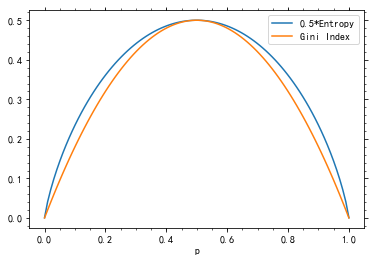

In [4]:
# 二分类情况下的熵和Gini系数
fg0, ax0 = plt.subplots()

p = np.linspace(0.0001, 0.9999, 100)
ax0.plot(p, 0.5*(-p*np.log2(p)-(1.-p)*np.log2(1.-p)), label='0.5*Entropy')
ax0.plot(p, p*(1.-p) + (1.-p)*p, label='Gini Index')
ax0.set_xlabel('p')
ax0.legend()

In [5]:
def gain(y_before, ys_after):
    """
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], , m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    gain : scalar
        information gain
    """
    m = y_before.shape[0]
    ys = set(y_before[:, 0].tolist())

    H0 = 0.
    for yval in ys:
        py = (y_before==yval).sum()/m
        H0 += -py*np.log2(py)

    H1 = 0.
    for y in ys_after:
        mx = y.shape[0]
        px = mx/m
        eps = 1./mx
        for yval in ys:
            pyx = (y==yval).sum()/mx
            if pyx < eps: continue
            H1 += px*(-pyx*np.log2(pyx))
            
    return H0-H1

def gain_ratio(y_before, ys_after):
    """
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], , m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    gain_ratio : scalar
        information gain ratio
    """
    m = y_before.shape[0]
    ys = set(y_before[:, 0].tolist())

    H0 = 0.
    for yval in ys:
        py = (y_before==yval).sum()/m
        H0 += -py*np.log2(py)

    H1, IV = 0., 0.
    for y in ys_after:
        mx = y.shape[0]
        px = mx/m
        IV += -px*np.log2(px)
        eps = 1./mx
        for yval in ys:
            pyx = (y==yval).sum()/mx
            if pyx < eps: continue
            H1 += px*(-pyx*np.log2(pyx))
            
    return (H0-H1)/IV

def gini_index(y_before, ys_after):
    """
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    gini_index : scalar
        Gini index
    """
    m = y_before.shape[0]
    ys = set(y_before[:, 0].tolist())
    
    G = 0.
    for y in ys_after:
        mx = y.shape[0]
        px = mx/m
        for yval in ys:
            py = (y==yval).sum()/mx
            G += px*(1.-py**2)
    return G

#### 一个例子

In [6]:
#!cat datasets/wm3.dat

In [7]:
raw = pd.read_table('datasets/wm3.dat', delimiter='\s+', index_col=0)
raw

,色泽,根蒂,敲声,纹理,脐部,触感,密度,含糖率,好瓜
#编号,,,,,,,,,
1,青绿,蜷缩,浊响,清晰,凹陷,硬滑,0.679,0.460,是
2,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,0.774,0.376,是
3,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,0.634,0.264,是
4,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,0.608,0.318,是
5,浅白,蜷缩,浊响,清晰,凹陷,硬滑,0.556,0.215,是
6,青绿,稍蜷,浊响,清晰,稍凹,软粘,0.403,0.237,是
7,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,0.481,0.149,是
8,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,0.437,0.211,是
9,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,0.666,0.091,否


In [8]:
X, y = raw.iloc[:, :-3].values, raw.iloc[:, -1:].values
colnames = raw.columns[:-3]

In [9]:
Xs_new, ys_new = split_attribute(X, y, 5)
print('gain={}, gain_ratio={}, Gini_index={}'.format(gain(y, ys_new), gain_ratio(y, ys_new), gini_index(y, ys_new)))

gain=0.006046489176565584, gain_ratio=0.0069183298534003, Gini_index=1.4941176470588236


{None: (3, '否'),
 '模糊': {None: (None, '否')},
 '清晰': {None: (1, '是'),
  '硬挺': {None: (None, '否')},
  '稍蜷': {None: (0, '是'),
   '青绿': {None: (None, '是')},
   '乌黑': {None: (5, '是'),
    '软粘': {None: (None, '否')},
    '硬滑': {None: (None, '是')}}},
  '蜷缩': {None: (None, '是')}},
 '稍糊': {None: (2, '否'),
  '浊响': {None: (4, '是'), '稍凹': {None: (None, '是')}, '凹陷': {None: (None, '否')}},
  '沉闷': {None: (None, '否')}}}

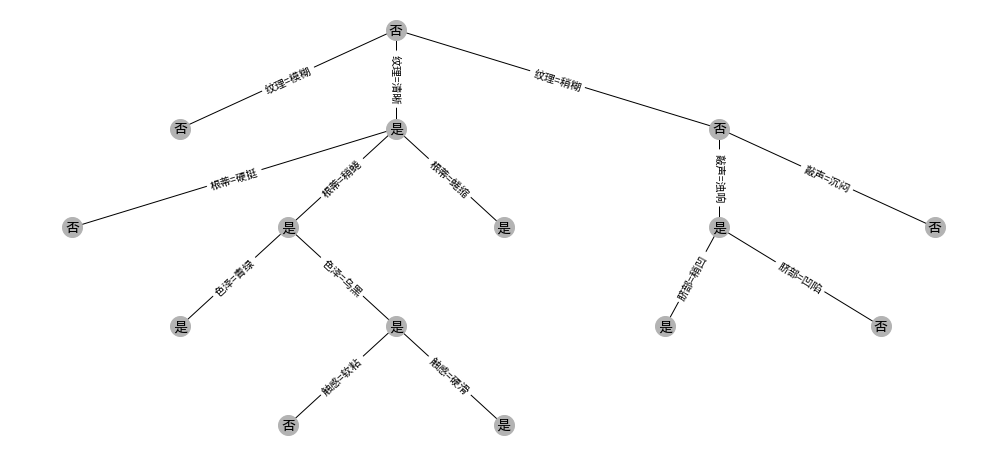

In [27]:
# ID3
tree0 = generate_tree(X, y, scorefunc=gain, maxdepth=None)
fg0 = tree_visualize(tree0, colnames)
tree0

In [29]:
classify(X, tree0).ravel(), y.ravel()

(array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype='<U1'),
 array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype=object))

{None: (3, '否'),
 '模糊': {None: (None, '否')},
 '清晰': {None: (5, '是'),
  '软粘': {None: (0, '否'),
   '青绿': {None: (1, '是'),
    '硬挺': {None: (None, '否')},
    '稍蜷': {None: (None, '是')}},
   '乌黑': {None: (None, '否')}},
  '硬滑': {None: (None, '是')}},
 '稍糊': {None: (2, '否'),
  '浊响': {None: (4, '是'), '稍凹': {None: (None, '是')}, '凹陷': {None: (None, '否')}},
  '沉闷': {None: (None, '否')}}}

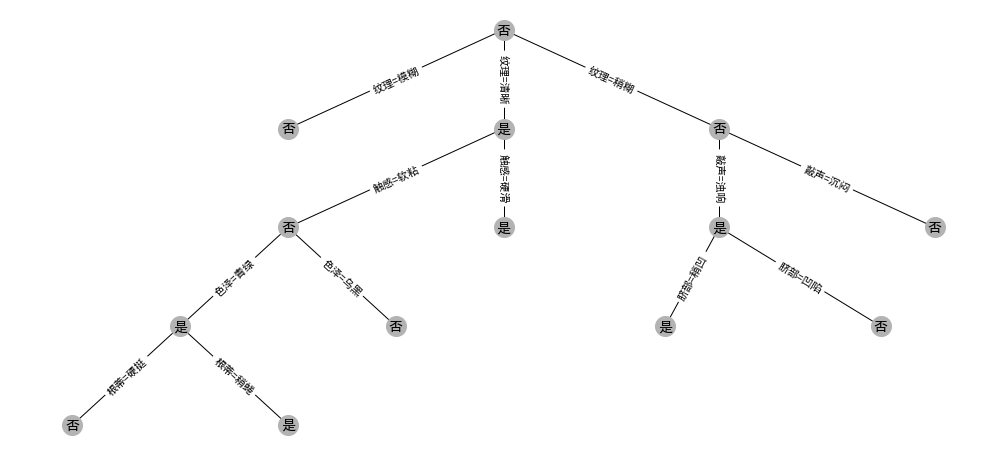

In [28]:
# C4.5
tree1 = generate_tree(X, y, scorefunc=gain_ratio, maxdepth=None)
fg1 = tree_visualize(tree1, colnames)
tree1

In [30]:
classify(X, tree1).ravel(), y.ravel()

(array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype='<U1'),
 array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype=object))

### 决策树的修剪
